Saved posture predictions with angles to 'posture_predictions_shoulder_ankle.csv'


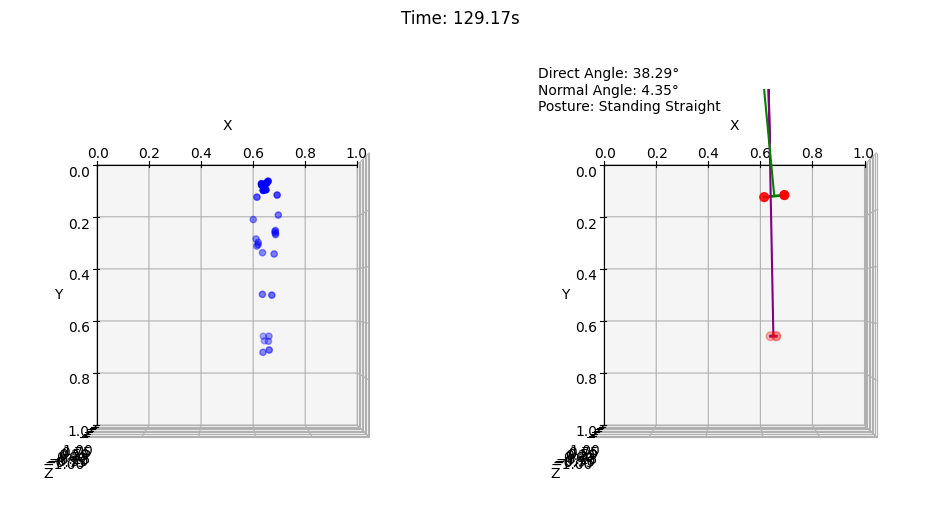

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Load CSV
df = pd.read_csv('J:/AI_Workshop_II_2/workshop_lifting-main/workshop_lifting-main/dataset_test.csv') 
time = df['time'].values
num_keypoints = 33
keypoints = np.zeros((len(df), num_keypoints, 3))

for i in range(num_keypoints):
    keypoints[:, i, 0] = df[f'keypoint_{i}_x']
    keypoints[:, i, 1] = df[f'keypoint_{i}_y']
    keypoints[:, i, 2] = df[f'keypoint_{i}_z']

# EMA smoothing
def ema_keypoints(keypoints, alpha=0.2):
    smoothed = np.copy(keypoints)
    for i in range(1, keypoints.shape[0]):
        smoothed[i] = alpha * keypoints[i] + (1 - alpha) * smoothed[i - 1]
    return smoothed

keypoints = ema_keypoints(keypoints)

# Keypoint indices
RIGHT_SHOULDER = 12
LEFT_SHOULDER = 11
RIGHT_ANKLE = 28  # เปลี่ยนจาก RIGHT_KNEE
LEFT_ANKLE = 27   # เปลี่ยนจาก LEFT_KNEE

# Create plot
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
sc1 = ax1.scatter([], [], [], c='b', s=20)
sc2 = ax2.scatter([], [], [], c='r', s=40)
shoulder_line, = ax2.plot([], [], [], 'g-', lw=2)
ankle_line, = ax2.plot([], [], [], 'purple', lw=2)  # เปลี่ยนจาก knee_line
angle_text = ax2.text2D(0.05, 0.95, "", transform=ax2.transAxes)

# ตัวแปรสำหรับเก็บ quiver objects
quiver_s = None
quiver_h = None

# ลิสต์สำหรับเก็บผลการทำนายและมุม
predictions = []
times = []
angles_raw = []
angles_normal = []

def init():
    for ax in (ax1, ax2):
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_zlim(-1, 1)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=-90, azim=-90)
    return sc1, sc2, shoulder_line, ankle_line, angle_text

def update(frame):
    global quiver_s, quiver_h
    
    kp = keypoints[frame]
    selected_ids = [RIGHT_SHOULDER, LEFT_SHOULDER, LEFT_ANKLE, RIGHT_ANKLE]
    selected = kp[selected_ids]
    sc1._offsets3d = (kp[:, 0], kp[:, 1], kp[:, 2])
    sc2._offsets3d = (selected[:, 0], selected[:, 1], selected[:, 2])

    # เวกเตอร์หลัก
    v_shoulder = kp[LEFT_SHOULDER] - kp[RIGHT_SHOULDER]
    v_ankle = kp[LEFT_ANKLE] - kp[RIGHT_ANKLE]

    # เส้นเวกเตอร์ในกราฟ
    shoulder_line.set_data([kp[RIGHT_SHOULDER][0], kp[LEFT_SHOULDER][0]],
                           [kp[RIGHT_SHOULDER][1], kp[LEFT_SHOULDER][1]])
    shoulder_line.set_3d_properties([kp[RIGHT_SHOULDER][2], kp[LEFT_SHOULDER][2]])
    ankle_line.set_data([kp[RIGHT_ANKLE][0], kp[LEFT_ANKLE][0]],
                        [kp[RIGHT_ANKLE][1], kp[LEFT_ANKLE][1]])
    ankle_line.set_3d_properties([kp[RIGHT_ANKLE][2], kp[LEFT_ANKLE][2]])

    # มุมแบบเดิม
    dot_v = np.dot(v_shoulder, v_ankle)
    norm_v = np.linalg.norm(v_shoulder) * np.linalg.norm(v_ankle)
    angle_raw = 0 if norm_v == 0 else np.degrees(np.arccos(np.clip(dot_v / norm_v, -1.0, 1.0)))

    # เวกเตอร์ตั้งฉาก
    vertical = np.array([0, 0, 1])
    n_shoulder = np.cross(v_shoulder, vertical)
    n_ankle = np.cross(v_ankle, vertical)

    # ลบ quiver เก่าก่อนวาดใหม่
    if quiver_s is not None:
        quiver_s.remove()
        quiver_h.remove()

    # วาดเวกเตอร์ตั้งฉาก
    origin_s = (kp[RIGHT_SHOULDER] + kp[LEFT_SHOULDER]) / 2
    origin_h = (kp[RIGHT_ANKLE] + kp[LEFT_ANKLE]) / 2
    scale = 0.2
    quiver_s = ax2.quiver(*origin_s, *(n_shoulder * scale), color='g', length=1, normalize=True)
    quiver_h = ax2.quiver(*origin_h, *(n_ankle * scale), color='purple', length=1, normalize=True)

    # มุมระหว่าง normal vectors
    dot_n = np.dot(n_shoulder, n_ankle)
    norm_n = np.linalg.norm(n_shoulder) * np.linalg.norm(n_ankle)
    angle_normal = 0 if norm_n == 0 else np.degrees(np.arccos(np.clip(dot_n / norm_n, -1.0, 1.0)))

    # จำแนกท่าทาง (ใช้ normal angle)
    threshold = 45
    if abs(angle_normal) < threshold or abs(180 - angle_normal) < threshold:
        posture = "Standing Straight"
    else:
        posture = "Twisting"

    # เก็บผลการทำนาย, เวลา, และมุม
    times.append(time[frame])
    predictions.append(posture)
    angles_raw.append(angle_raw)
    angles_normal.append(angle_normal)

    # แสดงผลลัพธ์
    angle_text.set_text(f"Direct Angle: {angle_raw:.2f}°\nNormal Angle: {angle_normal:.2f}°\nPosture: {posture}")
    fig.suptitle(f'Time: {time[frame]:.2f}s')
    return sc1, sc2, shoulder_line, ankle_line, angle_text

# รันแอนิเมชัน
ani = FuncAnimation(fig, update, frames=len(df), init_func=init, blit=False)
ani.save('mediapipe_3d_animation_with_angle_shoulder_ankle.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# สร้าง DataFrame จากผลการทำนายและมุม
prediction_df = pd.DataFrame({
    'Time': times,
    'Posture': predictions,
    'Direct Angle': angles_raw,
    'Normal Angle': angles_normal
})

# บันทึกผลลัพธ์ลงในไฟล์ CSV
prediction_df.to_csv('posture_predictions_with_shoulder_ankle.csv', index=False)
print("Saved posture predictions with angles to 'posture_predictions_shoulder_ankle.csv'")

# plt.show()  # ถ้าต้องการดูในหน้าจอ